In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import torch
from torchvision import transforms as transforms
from sklearn.model_selection import train_test_split

import pickle

from pathlib import Path
from utils import MHCoverDataset, get_dataloader
from utils.training import TrainingInterface
from utils.plots import EvaluationPlots
from torchvision.utils import make_grid
import PIL


# Purpose of this project

The aim of this project is to develop an image classification model, which should be able to classify different types of manhole covers . We don't have enough images to train the model. Sometimes we also have pictures of water pipe covers instead of manhole covers. The available images are all unlabelled. Now we have to find a solution to ensure correct classification of manhole covers.

# First exploratory data analysis

First we load the data:

In [2]:
df = pd.read_csv("data/labels_extra.csv")

Then we have to count the number of rows before removing the duplicated rows:

In [3]:
df.count()

image      2174
type       2174
subtype    2174
label      2174
set        2174
dtype: int64

Rows containing duplicate data:

In [4]:
duplicate_rows_df = df[df.duplicated()]
print("number of duplicate rows: ", duplicate_rows_df.shape)

number of duplicate rows:  (0, 5)


We do not have any duplicated rows (images) in our dataframe. Therefore we do not have to delete any rows out of our dataframe.

The dataframe we will work on looks like this:

In [5]:
df.head()

,image,type,subtype,label,set
0,100088800.png,Gussbeton,Pickelloch belueftet,Gussbeton / Pickelloch belueftet,train
1,100069600.png,Gussbeton,Pickelloch geschlossen,Gussbeton / Pickelloch geschlossen,train
2,100174700.png,Vollguss,Pickelloch belueftet,Vollguss / Pickelloch belueftet,train
3,100055100.png,Vollguss,Handgriff geschlossen,Vollguss / Handgriff geschlossen,train
4,100211100.png,Vollguss,Handgriff geschlossen,Vollguss / Handgriff geschlossen,train


In [6]:
df.shape

(2174, 5)

In total we have 2174 images of diffrent manhole covers. We have five columns of informations. The first row contains the image ID, which is always a unique number. Then we have a type and subtype of manhole covers. We also have a column with the combination of type and subtype called label. This column will be used for our further analysis and model. In the last column we get the information, if the image is in the test,train or validation set.

In [7]:
df.dtypes

image      object
type       object
subtype    object
label      object
set        object
dtype: object

Looking at the data types we see, that we only have objects in our dataframe. 

In [8]:
df.type.unique()

array(['Gussbeton', 'Vollguss', 'Rost', 'Andere'], dtype=object)

In the column "type", there are four values. Which means we can categorise the manhole covers in four diffrent main groups. 

In [9]:
df.subtype.unique()

array(['Pickelloch belueftet', 'Pickelloch geschlossen',
       'Handgriff geschlossen', 'Strassenrost', 'Einlauf rund', '-',
       'Strassenrost gewoelbt', 'Handgriff seitlich', 'Handgriff mitte',
       'Handgriff geschlossen, verschraubt', 'Aufklappbar'], dtype=object)

There are 13 subtypes in the dataset. Now we will visualize the data set with a count plot:

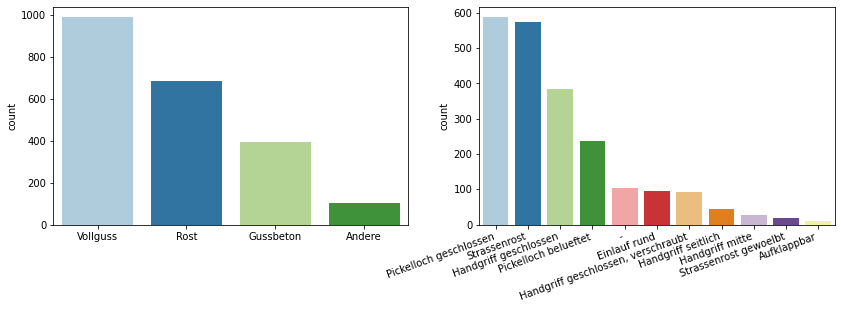

In [10]:
fig = plt.subplots(figsize=(14, 4))

plt.subplot(1,2,1)
p = sns.countplot(x=df['type'], palette='Paired', order=df['type'].value_counts().index)
p.set_xlabel('')

plt.subplot(1,2,2)
p = sns.countplot(x=df['subtype'], palette='Paired', order=df['subtype'].value_counts().index)

p.set_xlabel('')
p.set_xticklabels(p.get_xticklabels(), rotation=20, fontdict=dict(ha='right'))

plt.show()

This is a visualization with the distribution of the labels. 

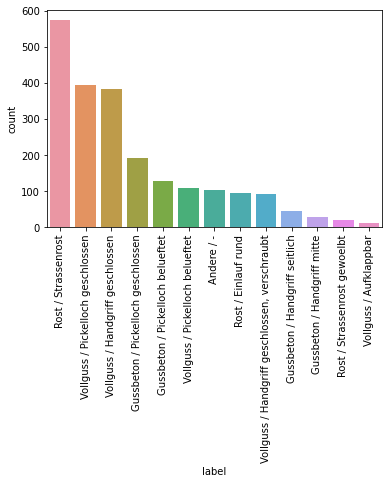

In [11]:
sns.countplot(x="label",data=df,order = df.label.value_counts().index)
plt.xticks(rotation = 90)
plt.show()

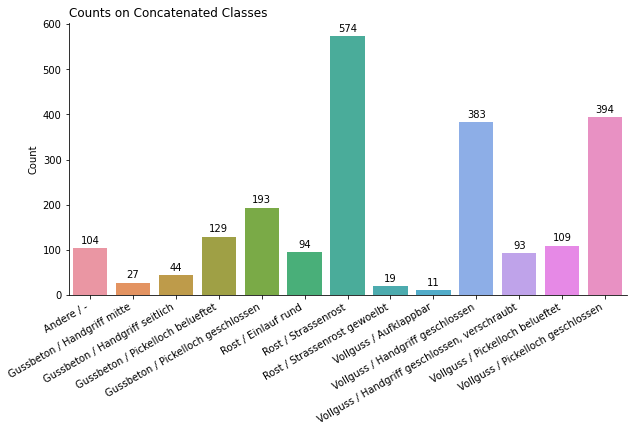

In [12]:
tmp = df.groupby('label').count()['image']

fig = plt.subplots(figsize=(10, 5))

p = sns.barplot(x=tmp.index, y=tmp)
p.set_xticklabels(labels=p.get_xticklabels(), ha='right', rotation=30)
p.set_xlabel('')
p.set_ylabel('Count')
p.set_title('Counts on Concatenated Classes', loc='left')

for i, val in enumerate(tmp.to_list()):
    plt.text(x=i, y=val+10, s=str(val), ha='center', )

sns.despine()
plt.show()

We can see that manhole covers with the label Rost/Strassenrost are the most prominent one in our data set. Afterwards we have Vollguss / Pickelloch geschlossen und Vollguss / Handgriff geschlossen. There is a huge imbalance in the data set. There are groups with way more images than others. This can be a big problem with our model. Therefore we have to come up with a strategy to avoid class imbalancement. 

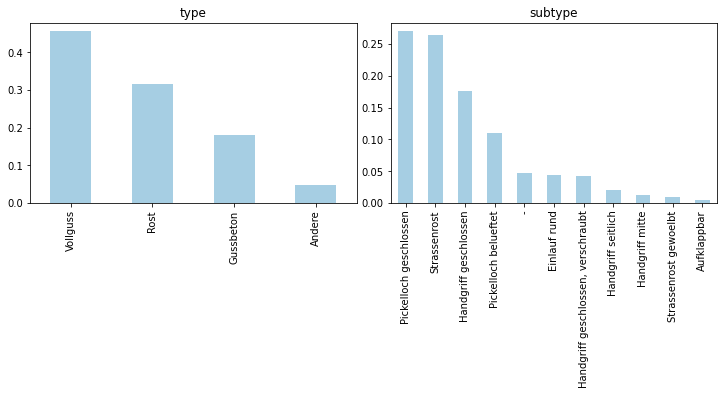

In [13]:
fig = plt.subplots(figsize=(10,8))

plt.subplot(221)
df.type.value_counts(normalize=True).plot(kind = 'bar', title = "type")
plt.tight_layout(pad=0.5)
plt.subplot(222)
df.subtype.value_counts(normalize=True).plot(kind = 'bar', title = "subtype")
plt.tight_layout(pad=0.5)

This is another visualization of the data, where we can see the distribution of the labels:

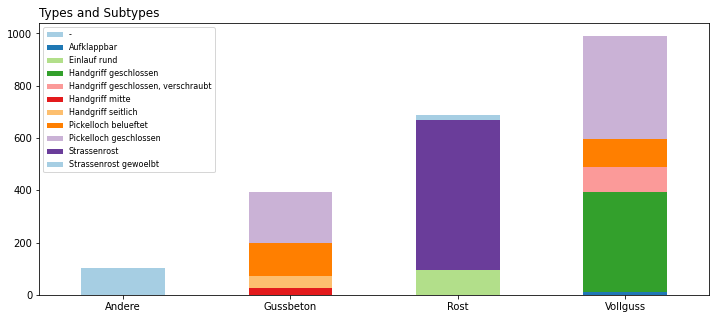

In [14]:
tmp = df.pivot_table(index='type', columns='subtype', 
                     values= 'image', aggfunc=len, fill_value=0)

p = tmp.plot(kind='bar', stacked=True, figsize=(12, 5), 
             color=sns.color_palette('Paired', 10) , xlabel='')
p.set_title('Types and Subtypes', loc='left')
p.set_xticklabels(labels=p.get_xticklabels(), rotation=0)
p.legend(fontsize=8)
plt.show()

We see here that within every type there are diffrent subtypes. These subtypes are also distributed imbalancly. 

# Train Test Split

In [15]:
df = df[df.label != "Andere / -"]
df.label = df.label.str.replace(r' / ', '/')

In [16]:
#Pickel file abelade
pkl_url_file = "utils/dataset/label_new.pkl"
with open(pkl_url_file, 'rb') as pkl_file:
    label_dict = pickle.load(pkl_file)
label_dict

{'Rost/Strassenrost': 0,
 'Vollguss/Pickelloch belueftet': 1,
 'Gussbeton/Pickelloch geschlossen': 2,
 'Vollguss/Pickelloch geschlossen': 3,
 'Gussbeton/Pickelloch belueftet': 4,
 'Vollguss/Handgriff geschlossen': 5,
 'Gussbeton/Handgriff seitlich': 6,
 'Rost/Einlauf rund': 7,
 'Rost/Strassenrost gewoelbt': 8,
 'Vollguss/Aufklappbar': 9,
 'Gussbeton/Handgriff mitte': 10,
 'Vollguss/Handgriff geschlossen, verschraubt': 11}

Split erklären

For our train and test and validation split we did not use a random split. We came up with the best strategy to avoid model manipulation. 

Text(0.5, 0, '')

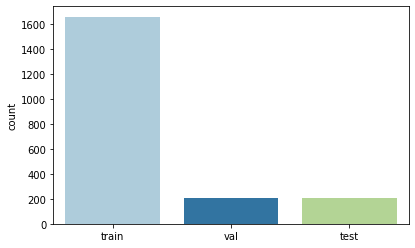

In [17]:
fig = plt.subplots(figsize=(14, 4))

plt.subplot(1,2,1)
p = sns.countplot(x=df['set'], palette='Paired', order=df['set'].value_counts().index)
p.set_xlabel('')

Here we see,m that we have split our 2174 images in three diffrent sets. The first set is the training set, which contains 80 % of the data.The second set is the test set and the third set is the validation set. These sets contain each 10 % of the data.

# Model RESNET18 

In [18]:
#Out of a variety of models the best result we got from the model RESNET18. We got a Accuracy of 0.886, which is 88.6% of true predictions. 

ResNet-18 is a convolutional neural network that is 18 layers deep. You can load a pretrained version of the network trained on more than a million images from the ImageNet database. The pretrained network can classify images into 1000 object categories, such as keyboard, mouse, pencil, and many animals. As a result, the network has learned rich feature representations for a wide range of images. The network has an image input size of 224-by-224. You can use classify to classify new images using the ResNet-18 model. 

There are 3 main components that make up the ResNet.
- input layer (conv1 + max pooling) (Usually referred to as layer 0)
- ResBlocks (conv2 without max pooing ~ conv5) (Usually referred to as layer1 ~ layer4)
- final layer

In [19]:
model152 = torch.load('resnet/152.pth')

In [20]:
my_test_transforms = transforms.Compose(
    [
        transforms.Resize(224),
        transforms.ToTensor(),
    ]
)

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [22]:
pkl_url_file = "utils/dataset/label_without_others.pkl"
root_dir = "data/images_transformed/"

In [23]:
testloader = get_dataloader(
    root_dir=root_dir,
    df=df[df.set =="test"].reset_index(),
    fp_label_translator=pkl_url_file,
    transformations=my_test_transforms,
    batch_size=32,
    workers=0,
    pin_memory=True,
    shuffle=True
)

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

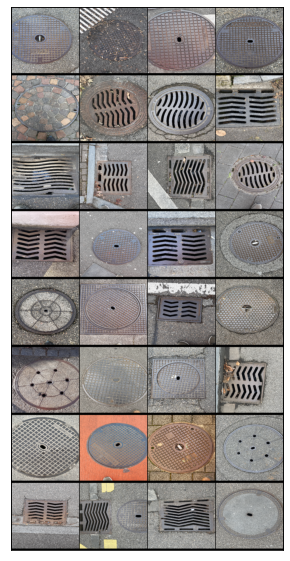

In [26]:
# Visualize one training batch
for images, labels in testloader:
    fig, ax = plt.subplots(figsize = (10, 10))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images, 4).permute(1,2,0))
    break

In [27]:
y_true, y_pred, y_prob, y_images = model152.predict(testloader)

Calculate Predictions:   0%|          | 0/7 [00:00<?, ?it/s]

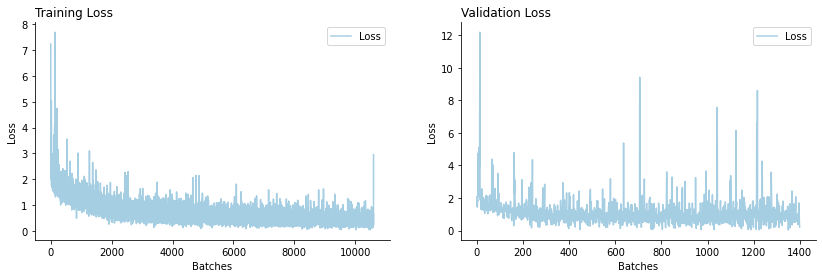

In [28]:
EvaluationPlots.plot_train_val_loss(model152.train_loss,model152.val_loss,)

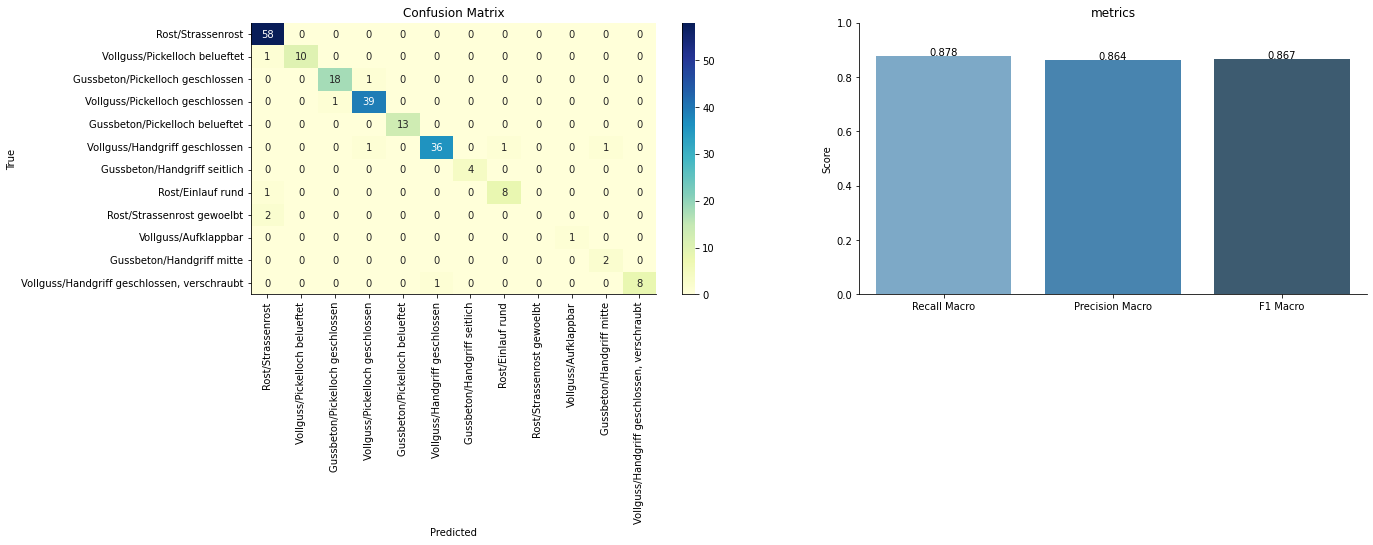

In [29]:
EvaluationPlots.metric_evaluation(y_true, y_pred,list(label_dict))

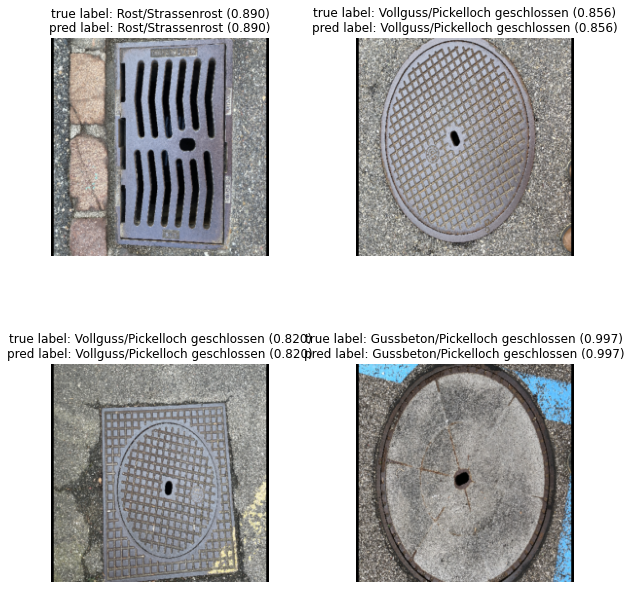

In [35]:
plot_pred(y_true, y_pred, y_images, y_prob,4, incorrect = False,label_dict=label_dict)

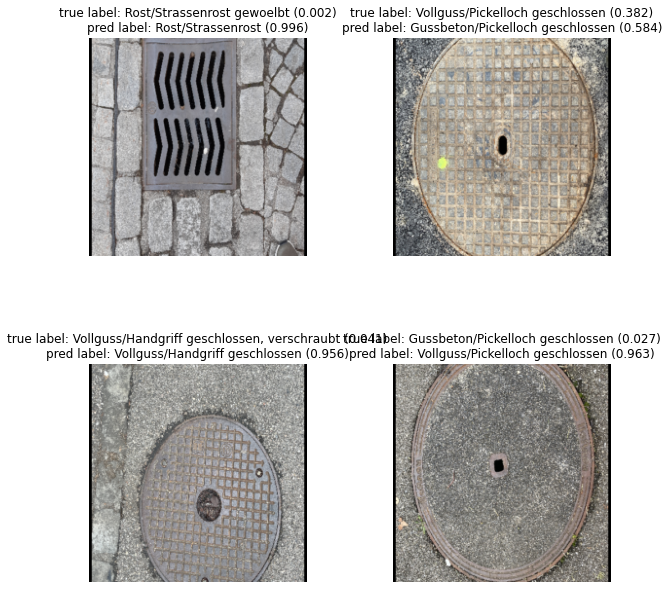

In [34]:
plot_pred(y_true, y_pred, y_images, y_prob,4, incorrect = True, label_dict=label_dict)

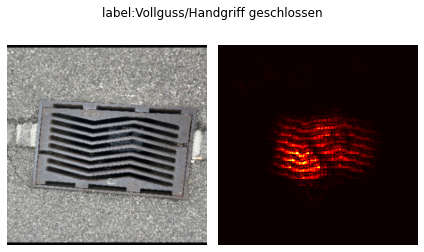

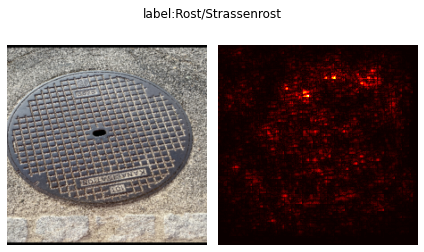

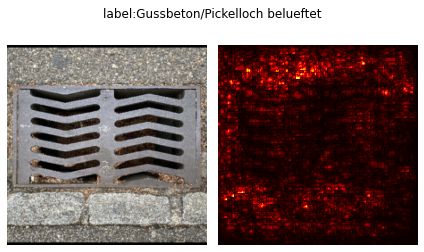

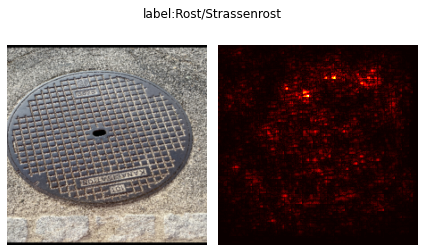

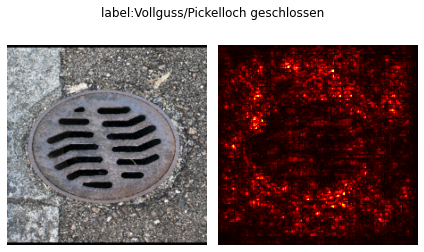

In [42]:
for i in range(5):
    imgg = "data/images_transformed/"+list(df.sample()["image"])[0]
    image = PIL.Image.open(imgg)
    image = my_test_transforms(image)
    image = image.reshape(1, 3, 224, 224)
    image = image.to(device)
    image.requires_grad_()
    output = model152.model(image)
    # Catch the output
    output_idx = output.argmax()
    output_max = output[0, output_idx]

    # Do backpropagation to get the derivative of the output based on the image
    output_max.backward()

    # Retireve the saliency map and also pick the maximum value from channels on each pixel.
    # In this case, we look at dim=1. Recall the shape (batch_size, channel, width, height)
    saliency, _ = torch.max(image.grad.data.abs(), dim=1) 
    saliency = saliency.reshape(224, 224)

    # Reshape the image
    image = image.reshape(-1, 224, 224)

    # Visualize the image and the saliency map
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(image.cpu().detach().numpy().transpose(1, 2, 0))
    ax[0].axis('off')
    ax[1].imshow(saliency.cpu(), cmap='hot')
    ax[1].axis('off')
    plt.tight_layout()
    fig.suptitle('label:'+list(df.sample()["label"])[0])
    plt.show()

# Conclusion

# Final Product

The final product is available on this Github repository: https://github.com/FiratSaritas/manhole-cover-model.git</br>
Our customer was successfully able to implement the model in their web application. We have a python file which will after running the code deliver a prediction for a given manhol cover. As default you will get three prediction probabilities but you can change the amount on your own. 
